In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [ ]:
#Data collection
data = yf.download(tickers='AAPL', start='2015-1-1', end='2023-12-31')
data = data['Close']
data

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2015-01-02,27.332500
2015-01-05,26.562500
2015-01-06,26.565001
2015-01-07,26.937500
2015-01-08,27.972500
...,...
2023-12-22,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [ ]:
# Data collection for future accuracy checking
actual_df = yf.download(tickers='AAPL',start='2023-12-28',end='2024-2-20')
actual_df = actual_df['Close']
actual_df.columns = ['Close']
actual_df

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2023-12-28,193.580002
2023-12-29,192.529999
2024-01-02,185.639999
2024-01-03,184.250000
2024-01-04,181.910004
2024-01-05,181.179993
2024-01-08,185.559998
2024-01-09,185.139999
2024-01-10,186.190002


In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

sequence_length = 50
x, y = create_sequences(data_scaled, sequence_length)

In [83]:
# Reshape input to [samples, time steps, features]
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [84]:
# Split into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Prerana Walvekar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
# Training model
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0314 - val_loss: 0.0023
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.6131e-04 - val_loss: 0.0018
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.7899e-04 - val_loss: 0.0015
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.5806e-04 - val_loss: 0.0026
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3428e-04 - val_loss: 0.0015
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.6491e-04 - val_loss: 0.0017
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.0624e-04 - val_loss: 0.0012
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.9770e-04 - val_loss: 0.0011
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.2346e-04 - val_loss: 0.0011
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3.3049e-04 - val_loss: 0.0010
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.1711e-04 - val_loss: 0.0011
Epoch 12/50
56/56 ━━━━━

In [ ]:
# Predict using test set
y_pred_scaled = model.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [88]:
# Inverse transform the scaled data
y_test = scaler.inverse_transform([y_test]).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

#y_test
#y_pred

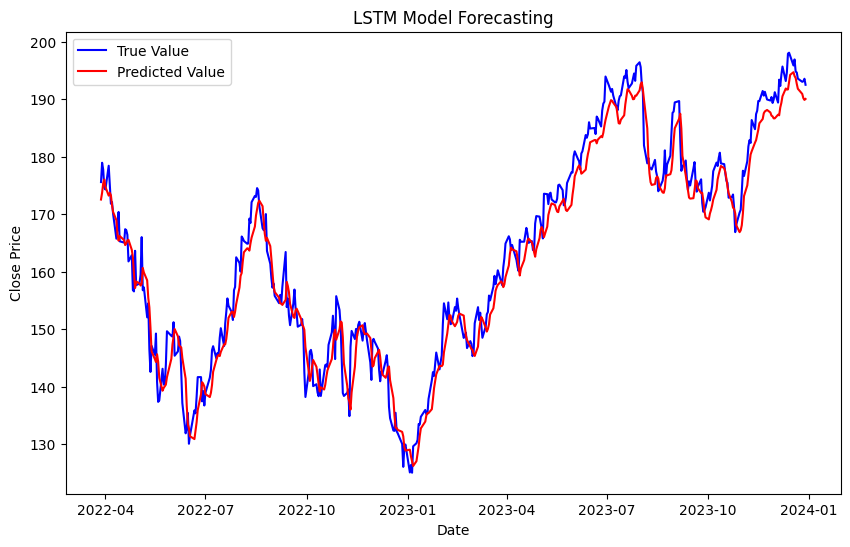

In [89]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='True Value', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Value', color='red')
plt.legend()
plt.title('LSTM Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**Prediction Accuracy**

In [96]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_actual = np.mean(y_test)

# Accuracy Calculation
accuracy = 100 - (rmse / mean_actual * 100)

print(f"RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

RMSE: 3.69
Accuracy: 97.74%


**Forecasting**

In [99]:
# Forecast future steps
def forecast_future(model, recent_data, n_steps):
    predictions = []
    current_input = recent_data.copy()

    for _ in range(n_steps):
        prediction = model.predict(current_input[np.newaxis, :, np.newaxis])
        predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1)
        current_input[-1] = prediction

    return np.array(predictions)

# Forecast next 30 days
recent_data = data_scaled[-sequence_length:].flatten()
future_steps = 22
future_forecast_scaled = forecast_future(model, recent_data, future_steps)
future_forecast = scaler.inverse_transform(future_forecast_scaled.reshape(-1, 1)).flatten()

print("Future Forecast (Next 30 Days):", future_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


C:\Users\Prerana Walvekar\AppData\Local\Temp\ipykernel_16344\2011505964.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Future Forecast (Next 30 Days): [189.94019 188.78415 187.35643 185.85196 184.34778 182.8837  181.48329
 180.16013 178.92033 177.76443 176.68881 175.68689 174.75038 173.87027
 173.03743 172.24341 171.480

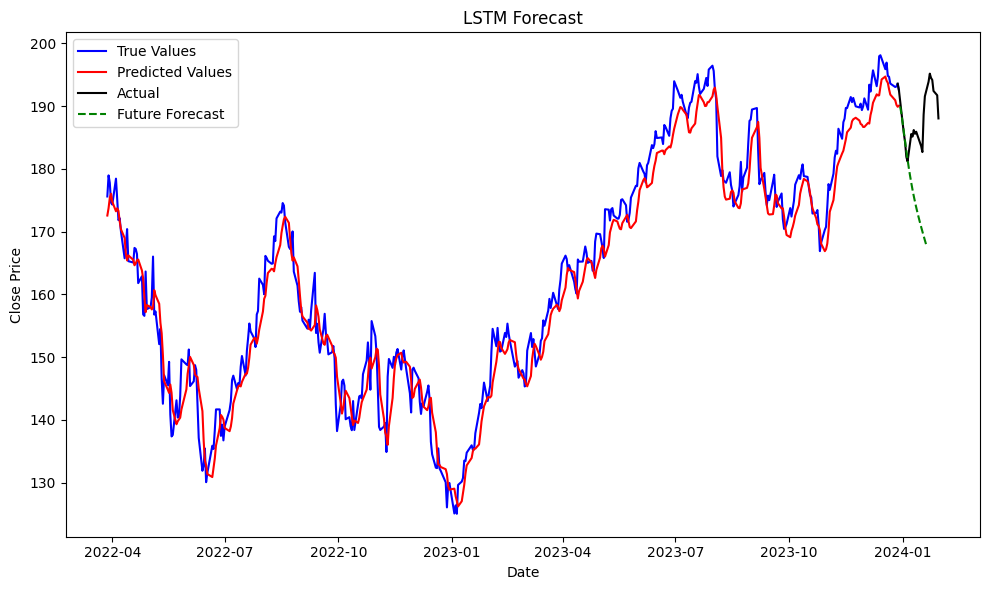

In [100]:
plt.figure(figsize=(10, 6))

# Plot historical true values
plt.plot(data.index[-len(y_test):], y_test, label="True Values", color='blue')

# Plot historical predictions
plt.plot(data.index[-len(y_test):], y_pred, label="Predicted Values", color='red')

# Plot actual values
plt.plot(actual_df['Close'],label='Actual',color='Black')

# Plot future forecast
future_dates = [data.index[-1] + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
plt.plot(future_dates, future_forecast, label="Future Forecast", color='green', linestyle='--')

# Show plot
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

**Prediction**

In [101]:
future_actual_prices = actual_df['Close'].values 

In [103]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape_forecast = np.mean(np.abs((future_actual_prices - future_forecast) / future_actual_prices)) * 100

# Calculate accuracy
accuracy_forecast = 100 - mape_forecast

# Print results
print(f"Forecasting Accuracy: {accuracy_forecast:.2f}%")
print(f"MAPE for Forecasting: {mape_forecast:.2f}%")


Forecasting Accuracy: 93.88%
MAPE for Forecasting: 6.12%
